In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform, he_uniform
tf.random.set_seed(27)

In [2]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")

In [3]:
print("Shape of the images: " + str(X_train[0].shape))
print("Example of measurement: " + str(y_train[0]))

Shape of the images: (76, 320, 3)
Example of measurement: -0.2


In [4]:
model = keras.Sequential()
model.add(layers.Lambda(lambda x: (x/255.0) - 0.5, input_shape=(76, 320, 3)))

model.add(layers.Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2)))
model.add(layers.Activation('elu'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))

model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2)))
model.add(layers.Activation('elu'))
#model.add(layers.MaxPooling2D((2, 2), padding='same'))

model.add(layers.Conv2D(filters=48, kernel_size=(3, 3)))
model.add(layers.Activation('elu'))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3)))
model.add(layers.Activation('elu'))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3)))
model.add(layers.Activation('elu'))
#model.add(layers.MaxPooling2D((2, 2), padding='same'))

model.add(layers.Flatten())

model.add(layers.Dense(100))
model.add(layers.Activation('elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50))
model.add(layers.Activation('elu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10))
model.add(layers.Activation('elu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 76, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 158, 24)       1824      
_________________________________________________________________
activation (Activation)      (None, 36, 158, 24)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 79, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 38, 32)         19232     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 38, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 36, 48)         1

In [5]:
epochs = 100
batch_size = 64
learning_rate = 0.0007

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss=keras.losses.mse,
              metrics=['mse'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mse',
                                                 factor=0.5,
                                                 patience=5,
                                                 min_lr=0.1*learning_rate,
                                                 verbose=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=10, verbose=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                            filepath="models/model_{epoch:02d}_{val_mse:.4f}.h5",
                                            monitor='val_mse',
                                            mode='min',
                                            verbose=1,
                                            save_best_only=True)

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping_callback, model_checkpoint_callback],
                    shuffle=True,
                    epochs=epochs,
                    verbose=1)

Epoch 1/100
1315/1315 [==============================] - 78s 38ms/step - loss: 0.0927 - mse: 0.0927 - val_loss: 0.0735 - val_mse: 0.0735

Epoch 00001: val_mse improved from inf to 0.07348, saving model to models/model_01_0.0735.h5
Epoch 2/100
1315/1315 [==============================] - 8s 6ms/step - loss: 0.0759 - mse: 0.0759 - val_loss: 0.0686 - val_mse: 0.0686

Epoch 00002: val_mse improved from 0.07348 to 0.06858, saving model to models/model_02_0.0686.h5
Epoch 3/100
1315/1315 [==============================] - 8s 6ms/step - loss: 0.0695 - mse: 0.0695 - val_loss: 0.0636 - val_mse: 0.0636

Epoch 00003: val_mse improved from 0.06858 to 0.06360, saving model to models/model_03_0.0636.h5
Epoch 4/100
1315/1315 [==============================] - 8s 6ms/step - loss: 0.0652 - mse: 0.0652 - val_loss: 0.0586 - val_mse: 0.0586

Epoch 00004: val_mse improved from 0.06360 to 0.05862, saving model to models/model_04_0.0586.h5
Epoch 5/100
1315/1315 [==============================] - 8s 6ms/step -

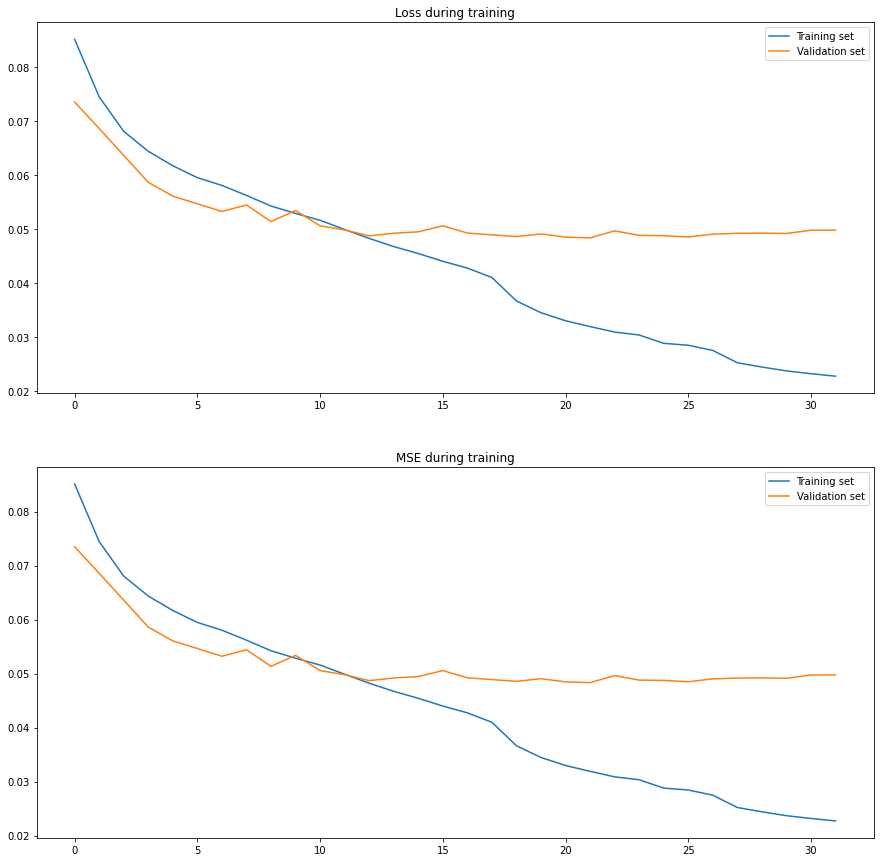

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Loss during training')
axs[0].legend(['Training set', 'Validation set'])

axs[1].plot(history.history['mse'])
axs[1].plot(history.history['val_mse'])
axs[1].title.set_text('MSE during training')
axs[1].legend(['Training set', 'Validation set'])

plt.show()